In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

from project_ssms.ar_truncated_normal_observation import ARTruncatedNormalObservation
from project_ssms.coupled_transformations.grid_transformation import GridTransformation
from project_ssms.unit_transformations import unit_direction_transformation
from project_ssms.feature_funcs import f_corner_vec_func, feature_direction_vec
from project_ssms.momentum_utils import filter_traj_by_speed, get_momentum_in_batch
from project_ssms.utils import downsample, k_step_prediction_for_lineargrid_model
from project_ssms.plot_utils import plot_z, plot_2_mice, plot_4_traces
from project_ssms.grid_utils import *

import torch
import numpy as np

import joblib
import pickle

import matplotlib.pyplot as plt

# load data

In [3]:
data_dir = "/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc/data/trajs_all"

trajs = joblib.load(data_dir)

traj = trajs[36000*0:36000*5]
traj = downsample(traj, 2)
data = torch.tensor(traj, dtype=torch.float64)

# load model

In [87]:
model_4by4_dir = "/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/grids/0922_v05_sticky/n2K6_4by4_D190922_020702/checkpoint_3/"
model_6by6_dir = "/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/grids/0922_v05_sticky/n2K6_6by6_D190922_021423/checkpoint_3/"
model_8by8_dir = "/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/grids/0922_v05_sticky/n2K6_8by8_D190922_024915/checkpoint_3/"

In [88]:
model_4by4 = joblib.load(model_4by4_dir + "model")
model_6by6 = joblib.load(model_6by6_dir + "model")
model_8by8 = joblib.load(model_8by8_dir + "model")

In [89]:
x_grids_4by4 = model_4by4.observation.transformation.x_grids
y_grids_4by4 = model_4by4.observation.transformation.y_grids

x_grids_6by6 = model_6by6.observation.transformation.x_grids
y_grids_6by6 = model_6by6.observation.transformation.y_grids

x_grids_8by8 = model_8by8.observation.transformation.x_grids
y_grids_8by8 = model_8by8.observation.transformation.y_grids


In [90]:
# read numbers
numbers_4 = joblib.load(model_4by4_dir + "numbers")
numbers_6 = joblib.load(model_6by6_dir + "numbers")
numbers_8 = joblib.load(model_8by8_dir + "numbers")

# samples

In [91]:
K = 6
sample_T = 90000

In [92]:
def z_to_color(z):
    for k in range(K):
        if z == k:
            return 'C{}'.format(k)

In [93]:
center_z = torch.tensor([1], dtype=torch.int)
center_x = torch.tensor([[150, 190, 200, 200]], dtype=torch.float64)

In [94]:
sample_z_4, sample_x_4 = model_4by4.sample(sample_T)
sample_z_center_4, sample_x_center_4 = model_4by4.sample(sample_T, prefix=(center_z, center_x))

In [95]:
colors_sample_z_4 = list(map(z_to_color, sample_z_4))
colors_sample_z_center_4 = list(map(z_to_color, sample_z_center_4))

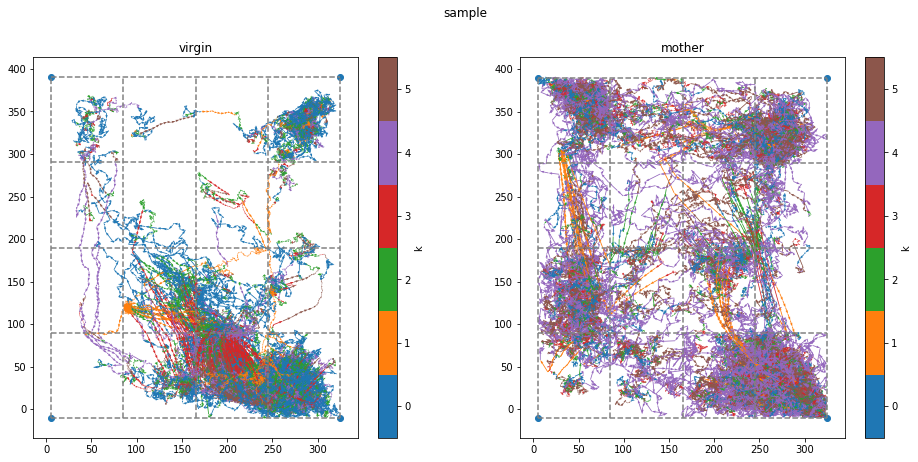

In [96]:
plot_realdata_quiver(sample_x_4, K, x_grids_4by4, y_grids_4by4, scale=1, title="sample", color=colors_sample_z_4)
plt.savefig(model_4by4_dir+"samples/quiver_sample_x_{}.jpg".format(sample_T), dpi=200)

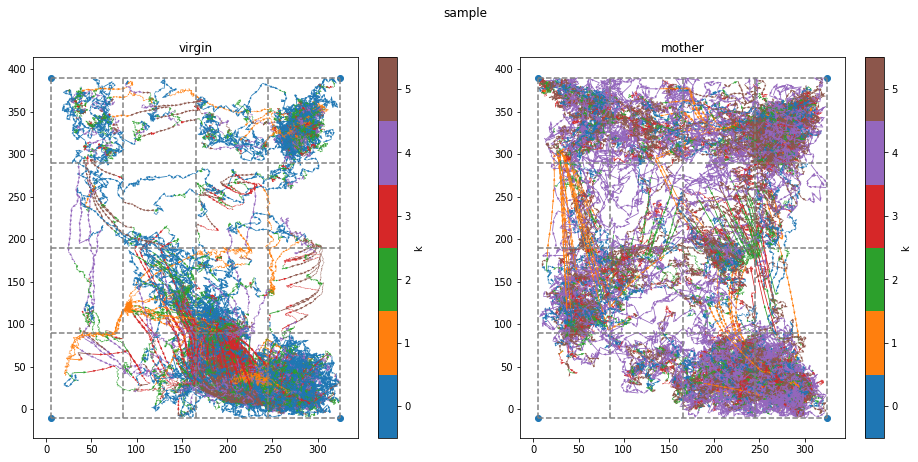

In [97]:
plot_realdata_quiver(sample_x_center_4, K, x_grids_4by4, y_grids_4by4, scale=1, title="sample", color=colors_sample_z_center_4)
plt.savefig(model_4by4_dir+"samples/quiver_sample_x_center_{}.jpg".format(sample_T), dpi=200)

In [98]:
# 6 by 6
sample_z_6, sample_x_6 = model_6by6.sample(sample_T)
sample_z_center_6, sample_x_center_6 = model_6by6.sample(sample_T, prefix=(center_z, center_x))

In [99]:
colors_sample_z_6 = list(map(z_to_color, sample_z_6))
colors_sample_z_center_6 = list(map(z_to_color, sample_z_center_6))

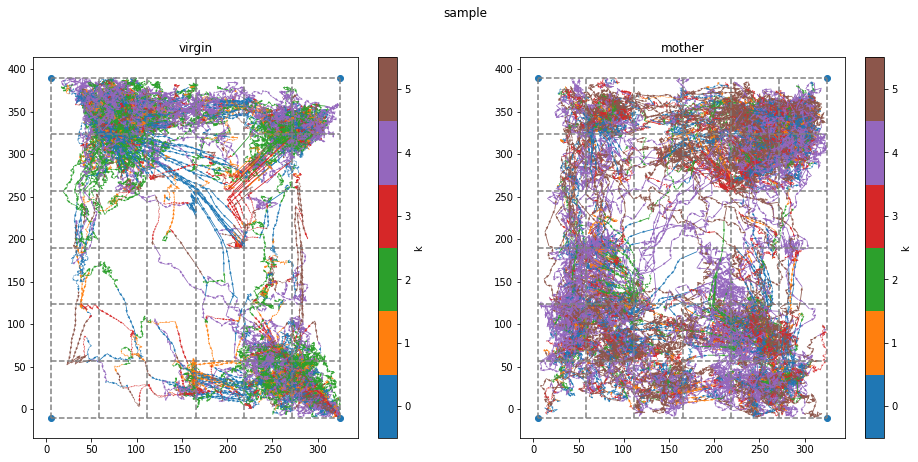

In [100]:
plot_realdata_quiver(sample_x_6, K, x_grids_6by6, y_grids_6by6, scale=1, title="sample", color=colors_sample_z_6)
plt.savefig(model_6by6_dir+"samples/quiver_sample_x_{}.jpg".format(sample_T), dpi=200)

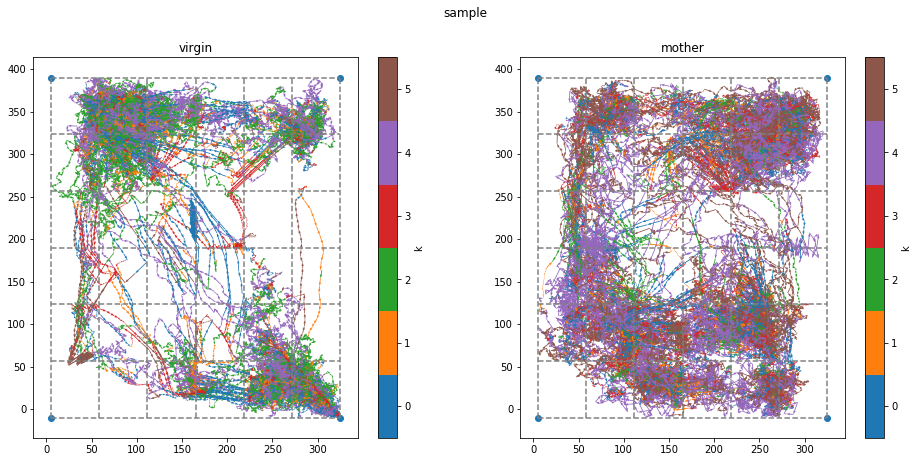

In [101]:
plot_realdata_quiver(sample_x_center_6, K, x_grids_6by6, y_grids_6by6, scale=1, title="sample", color=colors_sample_z_center_6)
plt.savefig(model_6by6_dir+"samples/quiver_sample_x_center_{}.jpg".format(sample_T), dpi=200)

In [102]:
# 8 by 8
sample_z_8, sample_x_8 = model_8by8.sample(sample_T)
sample_z_center_8, sample_x_center_8 = model_8by8.sample(sample_T, prefix=(center_z, center_x))

In [103]:
colors_sample_z_8 = list(map(z_to_color, sample_z_8))
colors_sample_z_center_8 = list(map(z_to_color, sample_z_center_8))

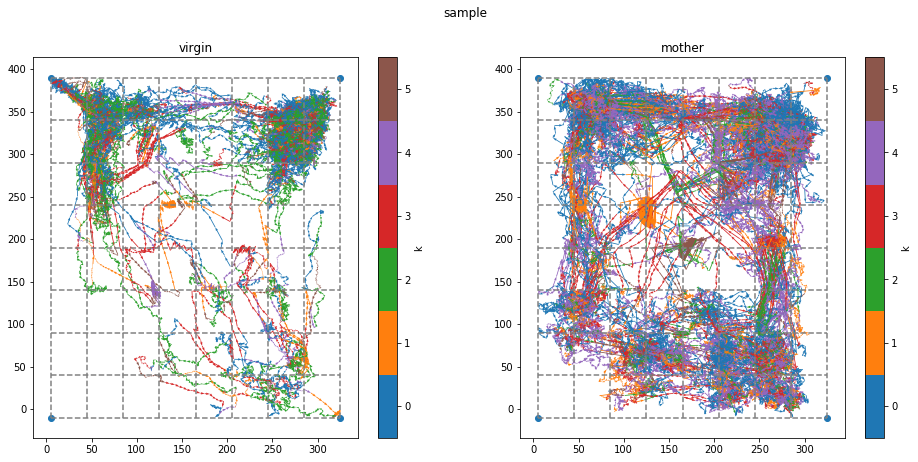

In [104]:
plot_realdata_quiver(sample_x_8, K, x_grids_8by8, y_grids_8by8, scale=1, title="sample", color=colors_sample_z_8)
plt.savefig(model_8by8_dir+"samples/quiver_sample_x_{}.jpg".format(sample_T), dpi=200)

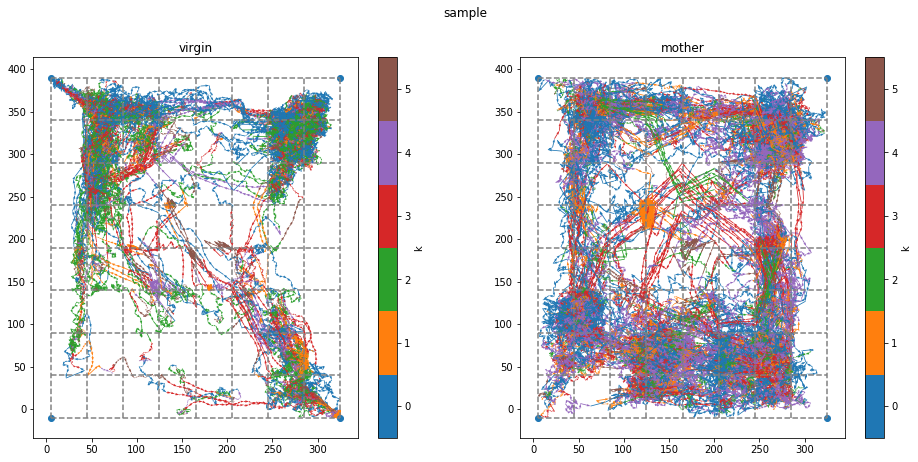

In [105]:
plot_realdata_quiver(sample_x_center_8, K, x_grids_8by8, y_grids_8by8, scale=1, title="sample", color=colors_sample_z_center_8)
plt.savefig(model_8by8_dir+"samples/quiver_sample_x_center_{}.jpg".format(sample_T), dpi=200)

In [106]:
# plot direction distribution
def plot_direction_dist(model_dir, x_grids, y_grids, sample_x, sample_x_center):
    n_x = len(x_grids) - 1
    n_y = len(y_grids) - 1
    data_angles_a, data_angles_b = get_all_angles(data, x_grids, y_grids)
    sample_angles_a, sample_angles_b = get_all_angles(sample_x, x_grids, y_grids)
    sample_x_center_angles_a, sample_x_center_angles_b = get_all_angles(sample_x_center, x_grids, y_grids)

    plot_list_of_angles([data_angles_a, sample_angles_a, sample_x_center_angles_a],
                        ['data', 'sample', 'sample_c'], "direction distribution (virgin)", n_x, n_y)
    plt.savefig(model_dir + "distributions/angles_a_{}.jpg".format(sample_T))
    plt.close()
    plot_list_of_angles([data_angles_b, sample_angles_b, sample_x_center_angles_b],
                        ['data', 'sample', 'sample_c'], "direction distribution (mother)", n_x, n_y)
    plt.savefig(model_dir + "distributions/angles_b_{}.jpg".format(sample_T))
    plt.close()

In [107]:
plot_direction_dist(model_4by4_dir, x_grids_4by4, y_grids_4by4, sample_x_4, sample_x_center_4)

In [108]:
plot_direction_dist(model_6by6_dir, x_grids_6by6, y_grids_6by6, sample_x_6, sample_x_center_6)

In [109]:
plot_direction_dist(model_8by8_dir, x_grids_8by8, y_grids_8by8, sample_x_8, sample_x_center_8)

In [110]:
numbers_4.keys()

dict_keys(['z', 'x_predict', 'x_predict_5', 'sample_z', 'sample_x', 'sample_z_center', 'sample_x_center', 'losses'])

In [111]:
numbers_4['sample_z_{}'.format(sample_T)] = sample_z_4
numbers_4['sample_x_{}'.format(sample_T)] = sample_x_4
numbers_4['sample_z_center_{}'.format(sample_T)] = sample_z_center_4
numbers_4['sample_x_center_{}'.format(sample_T)] = sample_x_center_4

numbers_6['sample_z_{}'.format(sample_T)] = sample_z_6
numbers_6['sample_x_{}'.format(sample_T)] = sample_x_6
numbers_6['sample_z_center_{}'.format(sample_T)] = sample_z_center_6
numbers_6['sample_x_center_{}'.format(sample_T)] = sample_x_center_6

numbers_8['sample_z_{}'.format(sample_T)] = sample_z_8
numbers_8['sample_x_{}'.format(sample_T)] = sample_x_8
numbers_8['sample_z_center_{}'.format(sample_T)] = sample_z_center_8
numbers_8['sample_x_center_{}'.format(sample_T)] = sample_x_center_8

In [112]:
joblib.dump(numbers_4, model_4by4_dir+"numbers")
joblib.dump(numbers_6, model_6by6_dir+"numbers")
joblib.dump(numbers_8, model_8by8_dir+"numbers")

['/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/grids/0922_v05_sticky/n2K6_8by8_D190922_024915/checkpoint_3/numbers']